In [0]:
!wget https://www.dropbox.com/s/h1n73cw33no99mz/data.pth

--2020-03-20 15:13:49--  https://www.dropbox.com/s/h1n73cw33no99mz/data.pth
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/h1n73cw33no99mz/data.pth [following]
--2020-03-20 15:13:49--  https://www.dropbox.com/s/raw/h1n73cw33no99mz/data.pth
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc201693bb42369b11c9cee40ce1.dl.dropboxusercontent.com/cd/0/inline/A0Sum2UgcEP9R-yaqAHt9icPPs0p1wSWdH10OvFzhBRVgorCxCfjxOXZDzC7qfFzf0wfmJWTGdk6_mbovb0xm0FD-A0zKFGw9ernuDfRi178nM3x68QfoQDp76n_A9NnNCI/file# [following]
--2020-03-20 15:13:49--  https://uc201693bb42369b11c9cee40ce1.dl.dropboxusercontent.com/cd/0/inline/A0Sum2UgcEP9R-yaqAHt9icPPs0p1wSWdH10OvFzhBRVgorCxCfjxOXZDzC7qfFzf0wfmJWTGdk6_mbovb0xm0FD-A0zKFGw9ernuDfRi178nM3x68QfoQDp76n_A9

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [0]:
train_x, train_y, dev_x, dev_y, test_x = torch.load('data.pth')

print('Training size:', train_x.shape, train_y.shape)
print('Development size:', dev_x.shape, dev_y.shape)
print('Test size:', test_x.shape)

Training size: (45000, 3, 32, 32) (45000,)
Development size: (5000, 3, 32, 32) (5000,)
Test size: (10000, 3, 32, 32)


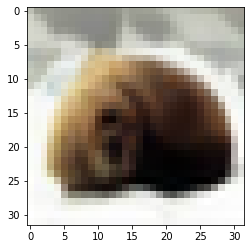

In [0]:
import random
random.seed(0)
sample_num =random.randint(1,len(train_x))
image = train_x[sample_num]
image_ = Variable(torch.from_numpy(image))
image_ = torch.unsqueeze(image_.permute(1, 2, 0), 0)
plt.imshow(image_.detach().cpu().numpy().squeeze())

In [0]:
def normalize_stats_image_by_image(images):
  mean = images.mean(axis=(1,2), keepdims=True)
  stdev = images.std(axis=(1,2), keepdims=True)
  return (images - mean) / (images.max() - images.min())
  
train_images = normalize_stats_image_by_image(train_x)
dev_images = normalize_stats_image_by_image(dev_x)
test_images = normalize_stats_image_by_image(test_x)

In [0]:
trx = Variable(torch.from_numpy(train_images))
dx = Variable(torch.from_numpy(dev_images))
tex = Variable(torch.from_numpy(test_images))
print(trx.shape)

torch.Size([45000, 3, 32, 32])


In [0]:
torch.cuda.is_available()
torch.cuda.empty_cache() 

In [0]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

# 模型需继承nn.Module
class VGG(nn.Module):
# 初始化参数：
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 100)

# 模型计算时的前向过程，也就是按照这个过程进行计算
    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)


In [0]:
model = VGG('VGG11')
model.cuda()
#x = torch.randn(2,3,32,32)
#print(model(Variable(x)).size())

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

In [0]:
def train_step(batch_size=128):
  
  model.train()

  input_batch, label_batch = batch(batch_size, training=True)
  #print(input_batch)
  output_batch = model(input_batch)
  #print(output_batch)
  loss = F.cross_entropy(output_batch, label_batch)
  train_loss = loss.item()
  _, pred_batch = torch.max(output_batch, dim=1)
  error_rate = 1.0 - (pred_batch == label_batch).float().mean()
  #correct = pred_batch.eq(output_batch).cpu().sum()
  #error_rate =1.0 - correct

  optimizer.zero_grad()
  loss.backward()
  
  optimizer.step()
  
  return train_loss, error_rate.item()#loss.item(), error_rate.item()

In [0]:
def val(batch_size=100):
  
  model.eval()
  input_batch, label_batch = batch(batch_size, training=False)
  output_batch = model(input_batch)

  loss = criterion(output_batch, label_batch)
  test_loss = loss.item()
  #print(loss)
  _, pred_batch = torch.max(output_batch, dim=1)
  error_rate = 1.0 - (pred_batch == label_batch).float().mean()
  #correct = pred_batch.eq(output_batch).cpu().sum()
  #error_rate =1.0 - correct
  return test_loss, error_rate.item() #loss.item(), error_rate.item()

In [0]:
def batch(batch_size, training=True):
  """Create a batch of examples.
  
  This creates a batch of input images and a batch of corresponding
  ground-truth labels. We assume CUDA is available (with a GPU).
  
  Args:
    batch_size: An integer.
    training: A boolean. If True, grab examples from the training
      set; otherwise, grab them from the validation set.
  
  Returns:
    A tuple,
    input_batch: A Variable of floats with shape
      [batch_size, 1, height, width]
    label_batch: A Variable of ints with shape
      [batch_size].
  """
  if training:
    random_ind = np.random.choice(train_images.shape[0], size=batch_size, replace=False)
    input_batch = train_images[random_ind]
    label_batch = train_y[random_ind]
  else:
    input_batch = dev_images[:batch_size]
    label_batch = dev_y[:batch_size]
  
  #input_batch = input_batch[:, np.newaxis, :, :]
  
  input_batch = torch.tensor(input_batch, requires_grad=False, device='cuda').type(torch.FloatTensor).cuda()
  label_batch = torch.tensor(label_batch, requires_grad=False, device='cuda')
  #print(input_batch.shape)
  return input_batch, label_batch


Step     0: Obtained a best validation error of 0.540.
Step    41: Obtained a best validation error of 0.530.
Step   167: Obtained a best validation error of 0.520.


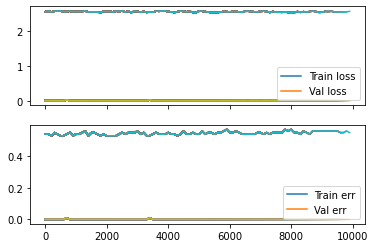

In [0]:
# Let's make sure we always start from scratch (that is,
# without starting from parameters from a previous run).
#for module in model.children():
  #module.reset_parameters()

info = []
fig, ax = plt.subplots(2, 1, sharex=True)
num_steps = 10000
num_steps_per_val = 100
best_val_err = 1.0
for step in range(num_steps):
  train_loss, train_err = train_step()
  val_loss, val_err = val()
  if val_err < best_val_err:
    best_val_err = val_err
    print('Step {:5d}: Obtained a best validation error of {:.3f}.'.format(step, best_val_err))
  if step % num_steps_per_val == 0:
    #print(val_loss)
    info.append([step, train_loss, val_loss, train_err, val_err])
    x, y11, y12, y21, y22 = zip(*info)
    ax[0].plot(x, y11, x, y12)
    ax[0].legend(['Train loss', 'Val loss'])
    ax[1].plot(x, y21, x, y22)
    ax[1].legend(['Train err', 'Val err'])
    #ax[1].set_ylim([0.0, 0.25])
    